In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.utils import class_weight
import numpy as np

import matplotlib as mtl
import matplotlib.pyplot as plt

import os

from data import transforms as T

In [2]:
class NYUv2Dataset(Dataset):
    def __init__(self, root: str, split: str, transform=None):
        self.root = os.path.join(root, split)

        for r, _, files in os.walk(self.root):
            if r.endswith('depth'):
                self.depth_paths = list(map(lambda x: os.path.join(r, x), files))
            elif r.endswith('image'):
                self.image_paths = list(map(lambda x: os.path.join(r, x), files))
            elif r.endswith('label'):
                self.label_paths = list(map(lambda x: os.path.join(r, x), files))

        self.depth_min, self.depth_max = self._get_depth_minmax()

        self.classes = self._get_classes()
        self.num_classes = len(self.classes)

        self.transform = transform

        print(f'\n[INFO] Dataset Loaded: NYUv2 ({split})')

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = np.load(self.image_paths[index]) # RGB image (288, 384, 3)
        depth = np.load(self.depth_paths[index]) # Depth ground truth [0, 10] (288, 384, 1)
        label = np.load(self.label_paths[index]) # Segmentation map (288, 384)

        # Reassign label -1 of uncategorize to highest value of category (13 in this case, 14th category)
        label[label == -1] = self.num_classes - 1

        sample = {'image': image,
                  'depth': depth.reshape((288,384)),    # Transform to shape (288, 384)
                  'label': label}
        
        if self.transform is not None:
            sample['image'] = self.transform(sample['image']) 
            sample['depth'] = self.transform(sample['depth']) 
            sample['label'] = self.transform(sample['label']) 
            
        return sample
    
    def __repr__(self) -> str:
        outstr = '[Dataset Information]\n'
        outstr += f'Number of images: {len(self.image_paths)} \n' 
        outstr += f'Depth values: min = {self.depth_min} | max = {self.depth_max} \n'
        outstr += f'Number of segmentation classes: {self.num_classes} ({self.classes})\n'
        return outstr
    
    def _get_classes(self) -> list:
        """ Get existing labels from the dataset """
        classes = []
        for f in self.label_paths:
            label = np.load(f) # load labels

            # Compute unique values
            unique_labels = list(np.unique(label))
            classes.extend(unique_labels)

        return list(set(classes))
    
    def _get_depth_minmax(self):
        """ Get min and max values in depth """
        min_val = 1000
        max_val = 0
        for f in self.depth_paths:
            depth = np.load(f) # load depth

            tmp_min = np.min(depth)
            tmp_max = np.max(depth)

            if tmp_min < min_val:
                min_val = tmp_min
            if tmp_max > max_val:
                max_val = tmp_max

        return min_val, max_val

In [3]:
path = './dataset/split_nyuv2/'

working_img = 0

In [4]:
transform = transforms.Compose([
    # transforms.Resize((480, 640)),
    transforms.ToTensor()
])

### Load Train Dataset for inspection

In [5]:
dataset = NYUv2Dataset(path, 'train', transform)
print(dataset)


[INFO] Dataset Loaded: NYUv2 (train)
[Dataset Information]
Number of images: 795 
Depth values: min = 0.0 | max = 9.989728927612305 
Number of segmentation classes: 14 ([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, -1.0])



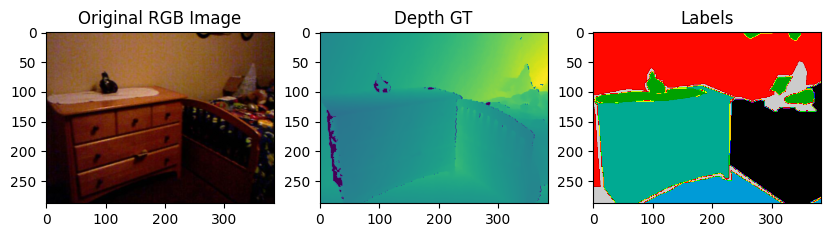

In [6]:
def show_sample(sample):
    img = sample['image'].permute(1,2,0).numpy()
    depth = sample['depth'].permute(1,2,0).numpy()
    label = sample['label'].permute(1,2,0).numpy()

    _, ax = plt.subplots(1, 3, figsize=(10,10))
    ax[0].imshow(img)
    ax[0].set_title('Original RGB Image')

    ax[1].imshow(depth, cmap='viridis')
    ax[1].set_title('Depth GT')

    ax[2].imshow(label, cmap='nipy_spectral') # nipy_spectral
    ax[2].set_title('Labels')

    plt.show()

show_sample(dataset[working_img])

In [7]:
def unpack_data(data):
    image, depth, label = data['image'], data['depth'], data['label']

    return image, depth, label

In [8]:
depth_min = []
depth_max = []
total_labels = []
count = 0

for data in dataset:
    image, depth, labels = unpack_data(data)

    depth_min.append(depth.min().item())
    depth_max.append(depth.max().item())

    if -1 in labels:
        count += 1
    total_labels.extend(labels.ravel().numpy().astype(int).tolist())

### Depths min/max

In [9]:
print(f'Minimum depth value: {min(depth_min)}')
print(f'Maximum depth value: {max(depth_max)}')

Minimum depth value: 0.0
Maximum depth value: 9.989728927612305


In [10]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.array(range(len(dataset.classes))), 
                                                  y=np.asanyarray(total_labels))

class_weights = torch.Tensor(class_weights).float()

print(f'Calculated weights distribution for cross-entropy loss: {class_weights}')

Calculated weights distribution for cross-entropy loss: tensor([ 1.7159, 11.6812,  9.7215,  1.7484,  0.6418,  0.4408,  0.4951,  3.7885,
         2.5581,  1.9729, 11.1400,  0.3180,  1.5640,  0.5633])


### Labels distribution

In [11]:
label_frequency = np.bincount(total_labels)
print(f'Number of present labels: {label_frequency.shape}')

Number of present labels: (14,)


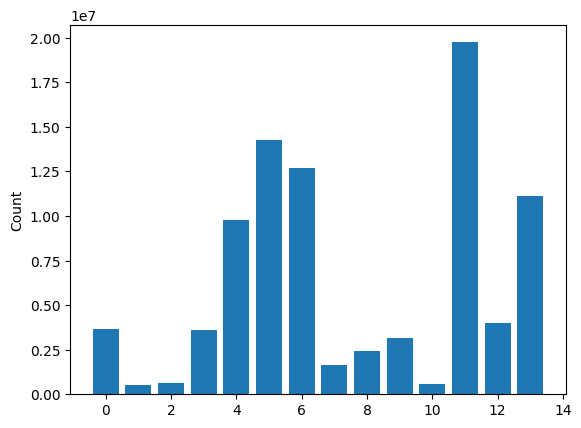

In [12]:
plt.bar(np.arange(0, len(label_frequency)), label_frequency)
plt.ylabel('Count')
# plt.title('Label frequency barchart')

plt.show()

In [14]:
print(label_frequency)

[ 3659913   537619   645997  3591798  9784982 14247939 12683181  1657673
  2454931  3183100   563740 19746634  4015320 11147813]


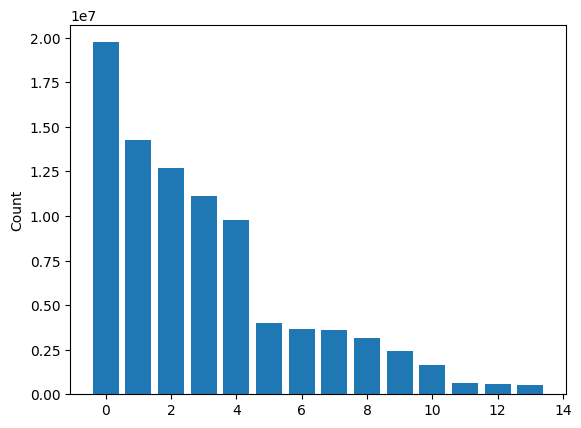

In [17]:
labels_ordered = np.sort(label_frequency)[::-1]
plt.bar(np.arange(0, len(labels_ordered)), labels_ordered)
plt.ylabel('Count')

plt.show()